# Carolo Mattia 232126

# Environment Configuration

initializing all work variables and libraries


In [23]:
import os

DEVICE = 'cuda:0'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [24]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
import random
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
import os
import json
from pprint import pprint
import torch.optim as optim
import sklearn
import matplotlib as mp
import matplotlib.pyplot as plt
import pandas as pd

# Data Preparation

## Download Datasets

Clone the repo containing ATIS and SNIPS and set their paths to be used later.

In [26]:
!git clone https://github.com/BrownFortress/IntentSlotDatasets.git

DATASET_PATHS = {"ATIS": "./IntentSlotDatasets/ATIS/", 
                 "SNIPS": "./IntentSlotDatasets/SNIPS/"}

fatal: destination path 'IntentSlotDatasets' already exists and is not an empty directory.


## Load Data

Load the datasets into a dictionary `dataset[<dataset_name>][<split>]` is a list of samples containing an utterance, intent, and a slot.

In [27]:
import os
import json
from pprint import pprint

dataset = dict()

for name, path in DATASET_PATHS.items():
    dataset[name] = dict()
    for split in ["train", "test", "valid"]:
        split_path = os.path.join(path, split + ".json")
        if os.path.exists(split_path):
            with open(split_path) as fp:
                dataset[name][split] = json.load(fp)
                print(name, split, len(dataset[name][split]))

train_raw_SNIPS = dataset['SNIPS']['valid']
pprint(train_raw_SNIPS[0])

ATIS train 4978
ATIS test 893
SNIPS train 13084
SNIPS test 700
SNIPS valid 700
{'intent': 'AddToPlaylist',
 'slots': 'O O O O O O B-music_item O B-playlist_owner B-playlist I-playlist O',
 'utterance': 'i d like to have this track onto my classical relaxations '
              'playlist'}


### Create validation set for the ATIS part

In [28]:
tmp_train_raw_ATIS = dataset['ATIS']['train']
test_raw_ATIS = dataset['ATIS']['test']
# First we get the 10% of dataset, then we compute the percentage of these examples 
# on the training set which is around 11% 
portion = round(((len(tmp_train_raw_ATIS) + len(test_raw_ATIS)) * 0.10)/(len(tmp_train_raw_ATIS)),2)


intents_ATIS = [x['intent'] for x in tmp_train_raw_ATIS] # We stratify on intents
count_y_ATIS = Counter(intents_ATIS)

Y_ATIS = []
X_ATIS = []
mini_Train_ATIS = []

for id_y, y in enumerate(intents_ATIS):
    # IT MAKES NO SENSE TO PUT IN DEV SET INTENTS THAT ONLY APPEAR ONCE
    if count_y_ATIS[y] > 1: # Some intents have only one instance, we put them in training
        X_ATIS.append(tmp_train_raw_ATIS[id_y])
        Y_ATIS.append(y)
    else:
        mini_Train_ATIS.append(tmp_train_raw_ATIS[id_y])
# Random Stratify
X_train_ATIS, X_dev_ATIS, y_train_ATIS, y_dev_ATIS = train_test_split(X_ATIS, Y_ATIS, test_size=portion, 
                                                    random_state=42, 
                                                    shuffle=True,
                                                    stratify=Y_ATIS)
X_train_ATIS.extend(mini_Train_ATIS)
train_raw_ATIS = X_train_ATIS
dev_raw_ATIS = X_dev_ATIS

y_test_ATIS = [x['intent'] for x in test_raw_ATIS]

# Intent distribution
print('Train:')
pprint({k:round(v/len(y_train_ATIS),3)*100 for k, v in sorted(Counter(y_train_ATIS).items())})
print('Dev:'), 
pprint({k:round(v/len(y_dev_ATIS),3)*100 for k, v in sorted(Counter(y_dev_ATIS).items())})
print('Test:') 
pprint({k:round(v/len(y_test_ATIS),3)*100 for k, v in sorted(Counter(y_test_ATIS).items())})
print('='*89)
# Dataset size
print('TRAIN size:', len(train_raw_ATIS))
print('DEV size:', len(dev_raw_ATIS))
print('TEST size:', len(test_raw_ATIS))

Train:
{'abbreviation': 2.9000000000000004,
 'aircraft': 1.6,
 'airfare': 8.5,
 'airline': 3.2,
 'airline+flight_no': 0.0,
 'airport': 0.4,
 'capacity': 0.3,
 'city': 0.4,
 'distance': 0.4,
 'flight': 73.7,
 'flight+airfare': 0.4,
 'flight_no': 0.3,
 'flight_time': 1.0999999999999999,
 'ground_fare': 0.4,
 'ground_service': 5.1,
 'meal': 0.1,
 'quantity': 1.0,
 'restriction': 0.1}
Dev:
{'abbreviation': 3.0,
 'aircraft': 1.7000000000000002,
 'airfare': 8.5,
 'airline': 3.2,
 'airport': 0.3,
 'capacity': 0.3,
 'city': 0.3,
 'distance': 0.3,
 'flight': 73.7,
 'flight+airfare': 0.5,
 'flight_no': 0.2,
 'flight_time': 1.0,
 'ground_fare': 0.3,
 'ground_service': 5.2,
 'meal': 0.2,
 'quantity': 1.0,
 'restriction': 0.2}
Test:
{'abbreviation': 3.6999999999999997,
 'aircraft': 1.0,
 'airfare': 5.4,
 'airfare+flight': 0.1,
 'airline': 4.3,
 'airport': 2.0,
 'capacity': 2.4,
 'city': 0.7000000000000001,
 'day_name': 0.2,
 'distance': 1.0999999999999999,
 'flight': 70.8,
 'flight+airfare': 1.3,
 

In [29]:
wordsATIS = sum([x['utterance'].split() for x in train_raw_ATIS], []) # No set() since we want to compute 
                                                            # the cutoff
corpusATIS = train_raw_ATIS + dev_raw_ATIS + test_raw_ATIS # We do not wat unk labels, 
                                        # however this depends on the research purpose
slotsATIS = set(sum([line['slots'].split() for line in corpusATIS],[]))
intentsATIS = set([line['intent'] for line in corpusATIS])

print(intentsATIS)

{'flight+airline', 'flight', 'flight+airfare', 'day_name', 'cheapest', 'flight_no+airline', 'airline+flight_no', 'ground_fare', 'quantity', 'meal', 'airfare+flight', 'flight_no', 'capacity', 'city', 'ground_service+ground_fare', 'abbreviation', 'airfare', 'airport', 'distance', 'restriction', 'aircraft+flight+flight_no', 'aircraft', 'airfare+flight_time', 'airline', 'ground_service', 'flight_time'}


In [30]:
train_raw_SNIPS = dataset['SNIPS']['train']
test_raw_SNIPS = dataset['SNIPS']['test']
dev_raw_SNIPS = dataset['SNIPS']['valid']
print('Train samples:', len(train_raw_SNIPS))
print('Test samples:', len(test_raw_SNIPS))
print('valid samples:', len(dev_raw_SNIPS))

pprint(dev_raw_SNIPS[0])

Train samples: 13084
Test samples: 700
valid samples: 700
{'intent': 'AddToPlaylist',
 'slots': 'O O O O O O B-music_item O B-playlist_owner B-playlist I-playlist O',
 'utterance': 'i d like to have this track onto my classical relaxations '
              'playlist'}


In [31]:
wordsSNIPS= sum([x['utterance'].split() for x in train_raw_ATIS], []) # No set() since we want to compute 
                                                            # the cutoff
corpusSNIPS = train_raw_SNIPS + dev_raw_SNIPS + test_raw_SNIPS # We do not wat unk labels, 
                                        # however this depends on the research purpose
slotsSNIPS = set(sum([line['slots'].split() for line in corpusSNIPS],[]))
intentsSNIPS = set([line['intent'] for line in corpusSNIPS])

print(intentsSNIPS)

{'PlayMusic', 'RateBook', 'AddToPlaylist', 'SearchScreeningEvent', 'GetWeather', 'SearchCreativeWork', 'BookRestaurant'}


## conll

In [32]:
"""
This script applies to IOB2 or IOBES tagging scheme.
If you are using a different scheme, please convert to IOB2 or IOBES.

IOB2:
- B = begin, 
- I = inside but not the first, 
- O = outside

e.g. 
John   lives in New   York  City  .
B-PER  O     O  B-LOC I-LOC I-LOC O

IOBES:
- B = begin, 
- E = end, 
- S = singleton, 
- I = inside but not the first or the last, 
- O = outside

e.g.
John   lives in New   York  City  .
S-PER  O     O  B-LOC I-LOC E-LOC O

prefix: IOBES
chunk_type: PER, LOC, etc.
"""
from __future__ import division, print_function, unicode_literals

import sys
from collections import defaultdict

def split_tag(chunk_tag):
    """
    split chunk tag into IOBES prefix and chunk_type
    e.g. 
    B-PER -> (B, PER)
    O -> (O, None)
    """
    if chunk_tag == 'O':
        return ('O', None)
    return chunk_tag.split('-', maxsplit=1)

def is_chunk_end(prev_tag, tag):
    """
    check if the previous chunk ended between the previous and current word
    e.g. 
    (B-PER, I-PER) -> False
    (B-LOC, O)  -> True

    Note: in case of contradicting tags, e.g. (B-PER, I-LOC)
    this is considered as (B-PER, B-LOC)
    """
    prefix1, chunk_type1 = split_tag(prev_tag)
    prefix2, chunk_type2 = split_tag(tag)

    if prefix1 == 'O':
        return False
    if prefix2 == 'O':
        return prefix1 != 'O'

    if chunk_type1 != chunk_type2:
        return True

    return prefix2 in ['B', 'S'] or prefix1 in ['E', 'S']

def is_chunk_start(prev_tag, tag):
    """
    check if a new chunk started between the previous and current word
    """
    prefix1, chunk_type1 = split_tag(prev_tag)
    prefix2, chunk_type2 = split_tag(tag)

    if prefix2 == 'O':
        return False
    if prefix1 == 'O':
        return prefix2 != 'O'

    if chunk_type1 != chunk_type2:
        return True

    return prefix2 in ['B', 'S'] or prefix1 in ['E', 'S']


def calc_metrics(tp, p, t, percent=True):
    """
    compute overall precision, recall and FB1 (default values are 0.0)
    if percent is True, return 100 * original decimal value
    """
    precision = tp / p if p else 0
    recall = tp / t if t else 0
    fb1 = 2 * precision * recall / (precision + recall) if precision + recall else 0
    if percent:
        return 100 * precision, 100 * recall, 100 * fb1
    else:
        return precision, recall, fb1


def count_chunks(true_seqs, pred_seqs):
    """
    true_seqs: a list of true tags
    pred_seqs: a list of predicted tags

    return: 
    correct_chunks: a dict (counter), 
                    key = chunk types, 
                    value = number of correctly identified chunks per type
    true_chunks:    a dict, number of true chunks per type
    pred_chunks:    a dict, number of identified chunks per type

    correct_counts, true_counts, pred_counts: similar to above, but for tags
    """
    correct_chunks = defaultdict(int)
    true_chunks = defaultdict(int)
    pred_chunks = defaultdict(int)

    correct_counts = defaultdict(int)
    true_counts = defaultdict(int)
    pred_counts = defaultdict(int)

    prev_true_tag, prev_pred_tag = 'O', 'O'
    correct_chunk = None

    for true_tag, pred_tag in zip(true_seqs, pred_seqs):
        if true_tag == pred_tag:
            correct_counts[true_tag] += 1
        true_counts[true_tag] += 1
        pred_counts[pred_tag] += 1

        _, true_type = split_tag(true_tag)
        _, pred_type = split_tag(pred_tag)

        if correct_chunk is not None:
            true_end = is_chunk_end(prev_true_tag, true_tag)
            pred_end = is_chunk_end(prev_pred_tag, pred_tag)

            if pred_end and true_end:
                correct_chunks[correct_chunk] += 1
                correct_chunk = None
            elif pred_end != true_end or true_type != pred_type:
                correct_chunk = None

        true_start = is_chunk_start(prev_true_tag, true_tag)
        pred_start = is_chunk_start(prev_pred_tag, pred_tag)

        if true_start and pred_start and true_type == pred_type:
            correct_chunk = true_type
        if true_start:
            true_chunks[true_type] += 1
        if pred_start:
            pred_chunks[pred_type] += 1

        prev_true_tag, prev_pred_tag = true_tag, pred_tag
    if correct_chunk is not None:
        correct_chunks[correct_chunk] += 1

    return (correct_chunks, true_chunks, pred_chunks, 
        correct_counts, true_counts, pred_counts)

def get_result(correct_chunks, true_chunks, pred_chunks,
    correct_counts, true_counts, pred_counts, verbose=True):
    """
    if verbose, print overall performance, as well as preformance per chunk type;
    otherwise, simply return overall prec, rec, f1 scores
    """
    # sum counts
    sum_correct_chunks = sum(correct_chunks.values())
    sum_true_chunks = sum(true_chunks.values())
    sum_pred_chunks = sum(pred_chunks.values())

    sum_correct_counts = sum(correct_counts.values())
    sum_true_counts = sum(true_counts.values())

    nonO_correct_counts = sum(v for k, v in correct_counts.items() if k != 'O')
    nonO_true_counts = sum(v for k, v in true_counts.items() if k != 'O')

    chunk_types = sorted(list(set(list(true_chunks) + list(pred_chunks))))

    # compute overall precision, recall and FB1 (default values are 0.0)
    prec, rec, f1 = calc_metrics(sum_correct_chunks, sum_pred_chunks, sum_true_chunks)
    res = (prec, rec, f1)
    if not verbose:
        return res

    # print overall performance, and performance per chunk type
    
    print("processed %i tokens with %i phrases; " % (sum_true_counts, sum_true_chunks), end='')
    print("found: %i phrases; correct: %i.\n" % (sum_pred_chunks, sum_correct_chunks), end='')
    try:
        print("accuracy: %6.2f%%; (non-O)" % (100*nonO_correct_counts/nonO_true_counts))
        print("accuracy: %6.2f%%; " % (100*sum_correct_counts/sum_true_counts), end='')
        print("precision: %6.2f%%; recall: %6.2f%%; FB1: %6.2f" % (prec, rec, f1))
    except ZeroDivisionError:
        print("conll doesn't work")

    # for each chunk type, compute precision, recall and FB1 (default values are 0.0)
    for t in chunk_types:
        prec, rec, f1 = calc_metrics(correct_chunks[t], pred_chunks[t], true_chunks[t])
        print("%17s: " %t , end='')
        print("precision: %6.2f%%; recall: %6.2f%%; FB1: %6.2f" %
                    (prec, rec, f1), end='')
        print("  %d" % pred_chunks[t])

    return res
    # you can generate LaTeX output for tables like in
    # http://cnts.uia.ac.be/conll2003/ner/example.tex
    # but I'm not implementing this

def evaluate(true_seqs, pred_seqs, verbose=True):
    (correct_chunks, true_chunks, pred_chunks,
        correct_counts, true_counts, pred_counts) = count_chunks(true_seqs, pred_seqs)
    result = get_result(correct_chunks, true_chunks, pred_chunks,
        correct_counts, true_counts, pred_counts, verbose=verbose)
    return result

## Lang and Dataset Classes

The `Lang` class stores information about the vocabulary and output labels. Each word/intent/slot label is mapped to an integer. These integers are then fed into the embedding layers of the neural models.

`Dataset` is for dividing the whole dataset into smaller batches.

In [52]:
import torch
import torch.utils.data as data

class Lang:#Alphabet like structure from Process.py in stackPropagatin
    PAD_TOKEN = '[PAD]'
    UNK_TOKEN = '[UNK]'

    def __init__(self):
        self._vocab = []
        self._word_ids = dict()
        self._intents = []
        self._intent_ids = dict()
        self._slots = []
        self._slot_ids = dict()

    def build_vocab(self, data):
        vocab = set()
        for x in data:
            vocab = vocab.union(set(x['utterance'].split()))
        self._vocab = [Lang.PAD_TOKEN] + list(vocab) + [Lang.UNK_TOKEN]
        self._word_ids = dict((w, i) for i, w in enumerate(self._vocab))

    def build_intents(self, data):
        self._intents = list(set(x['intent'] for x in data))
        self._intent_ids = dict((w, i) for i, w in enumerate(self._intents))

    def build_slots(self, data):
        slots = set()
        for x in data:
            slots = slots.union(set(x['slots'].split()))
        self._slots = list(slots)
        self._slot_ids = dict((w, i) for i, w in enumerate(self._slots))
    
    def get_word_id(self, word):
        if word in self._word_ids:
            return self._word_ids[word]
        else:
            return self._word_ids[Lang.UNK_TOKEN]
    
    def get_intent_id(self, intent):
        return self._intent_ids[intent]
    
    def get_slot_id(self, intent):
        return self._slot_ids[intent]
    
    def get_slot_label(self, i):
        return self._slots[i]

    def get_intent_label(self, i):
        return self._intents[i]
    
    def get_word(self, i):
        return self._vocab[i]
    
    @property
    def vocab_size(self):
        return len(self._vocab)
    
    @property
    def num_intents(self):
        return len(self._intents)
    
    @property
    def num_slots(self):
        return len(self._slots)
    
    @property
    def vocab(self):
        return self._vocab

class Dataset(data.Dataset):

    def __init__(self, data, lang):
        self._x = []
        self._y_intent = []
        self._y_slot = []

        for sample in data:
            utter_ids = list(map(lang.get_word_id, sample['utterance'].split()))
            slot_ids = list(map(lang.get_slot_id, sample['slots'].split()))
            self._x.append(utter_ids)
            self._y_slot.append(slot_ids)
            self._y_intent.append(lang.get_intent_id(sample['intent']))
    
    def __len__(self):
        return len(self._x)

    def __getitem__(self, i):
        x = torch.Tensor(self._x[i])
        y_intent = self._y_intent[i]
        y_slot = torch.Tensor(self._y_slot[i])
        return {'utterance': x, 'intent': y_intent, 'slots': y_slot}

def collate_fn(data):
    def merge(sequences):
        lengths = [len(seq) for seq in sequences]
        max_len = 1 if max(lengths)==0 else max(lengths)
        padded_seqs = torch.LongTensor(len(sequences),max_len).fill_(0)
        for i, seq in enumerate(sequences):
            end = lengths[i]
            padded_seqs[i, :end] = seq
        padded_seqs = padded_seqs.detach()
        return padded_seqs, lengths

    data.sort(key=lambda x: len(x['utterance']), reverse=True) 
    new_item = {}
    for key in data[0].keys():
        new_item[key] = [d[key] for d in data]
    src_utt, _ = merge(new_item['utterance'])
    y_slots, y_lengths = merge(new_item["slots"])
    intent = torch.LongTensor(new_item["intent"])
    
    src_utt = src_utt.to(DEVICE)
    y_slots = y_slots.to(DEVICE)
    intent = intent.to(DEVICE)
    y_lengths = torch.LongTensor(y_lengths).to(DEVICE)
    
    new_item["utterances"] = src_utt
    new_item["intents"] = intent
    new_item["y_slots"] = y_slots
    new_item["slots_len"] = y_lengths
    return new_item


- old implementation of lang used for stack propagation

In [53]:
PAD_TOKEN = '[PAD]'
UNK_TOKEN = '[UNK]'

from collections import Counter
class Langa():
    def __init__(self, words, intents, slots, cutoff=0):
        self.word2id = self.w2id(words, cutoff=cutoff, unk=True)
        self.slot2id = self.lab2id(slots)
        self.intent2id = self.lab2id(intents, pad=False)
        self.id2word = {v:k for k, v in self.word2id.items()}
        self.id2slot = {v:k for k, v in self.slot2id.items()}
        self.id2intent = {v:k for k, v in self.intent2id.items()}
        
    def w2id(self, elements, cutoff=None, unk=True):
        vocab = {'pad': PAD_TOKEN}
        if unk:
            vocab['unk'] = len(vocab)
        count = Counter(elements)
        for k, v in count.items():
            if v > cutoff:
                vocab[k] = len(vocab)
        return vocab
    
    def lab2id(self, elements, pad=True):
        vocab = {}
        if pad:
            vocab['pad'] = PAD_TOKEN
        for elem in elements:
                vocab[elem] = len(vocab)
        return vocab

In [54]:
#lang_ATIS = Lang(wordsATIS,intentsATIS,slotsATIS,cutoff = 0)
#lang_SNIPS = Lang(wordsSNIPS,intentsSNIPS,slotsSNIPS,cutoff = 0)

In [57]:
words_ATIS = sum([x['utterance'].split() for x in train_raw_ATIS], []) # No set() since we want to compute 
                                                            # the cutoff
corpus_ATIS = train_raw_ATIS + dev_raw_ATIS + test_raw_ATIS # We do not wat unk labels, 
                                        # however this depends on the research purpose
slots_ATIS = set(sum([line['slots'].split() for line in corpus_ATIS],[]))
intents_ATIS = set([line['intent'] for line in corpus_ATIS])

#lang_ATIS = Lang(words_ATIS, intents_ATIS, slots_ATIS, cutoff=0)

pprint(len(intents_ATIS))

26


In [58]:
words_SNIPS = sum([x['utterance'].split() for x in train_raw_SNIPS], []) # No set() since we want to compute 
                                                            # the cutoff
corpus_SNIPS = train_raw_SNIPS + dev_raw_SNIPS + test_raw_SNIPS # We do not wat unk labels, 
                                        # however this depends on the research purpose
slots_SNIPS = set(sum([line['slots'].split() for line in corpus_SNIPS],[]))
intents_SNIPS = set([line['intent'] for line in corpus_SNIPS])

#lang_SNIPS = Lang(words_SNIPS, intents_SNIPS, slots_SNIPS, cutoff=0)

# Bi-model RNN

Wang, Yu, Yilin Shen, and Hongxia Jin. "A bi-model based rnn semantic frame parsing model for intent detection and slot filling." arXiv preprint [arXiv:1812.10235](https://arxiv.org/abs/1812.10235) (2018).

Original code: https://github.com/ray075hl/Bi-Model-Intent-And-Slot

In [40]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class BiModelRNN(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_intents, num_slots, vocab_size):
        super(BiModelRNN, self).__init__()
        self._embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self._intent_enc = nn.LSTM(embed_dim, hidden_dim, 2, bidirectional=True)
        self._slot_enc = nn.LSTM(embed_dim, hidden_dim, 2, bidirectional=True)
        self._y_intent1 = nn.Linear(2 * hidden_dim, 2 * hidden_dim)
        self._y_intent2 = nn.Linear(2 * hidden_dim, num_intents)
        self._y_slot1 = nn.Linear(2 * hidden_dim, 2 * hidden_dim)
        self._y_slot2 = nn.Linear(2 * hidden_dim, num_slots)

    def forward(self, input, seq_lens):
        x = self._embed(input).permute(1, 0, 2)
        x = pack_padded_sequence(x, seq_lens.cpu().numpy())
        with torch.no_grad():
            _, (h1, s1) = self._intent_enc(x)
            _, (h2, s2) = self._slot_enc(x)
        y_intent, _ = self._intent_enc(x, (h2, s1))
        y_slot, _ = self._slot_enc(x, (h1, s2))
        y_intent = self._y_intent1(pad_packed_sequence(y_intent)[0])
        y_slot = self._y_slot1(pad_packed_sequence(y_slot)[0])
        self._h_intent, self._s_intent = h1.detach(), s1.detach()
        self._h_slot, self._s_slot = h2.detach(), s2.detach()
        return self._y_intent2(y_intent[-1,:,:]), self._y_slot2(y_slot).permute(1, 2, 0)

# Attention Bi-RNN

Liu, Bing, and Ian Lane. "Attention-based recurrent neural network models for joint intent detection and slot filling." arXiv preprint [arXiv:1609.01454](https://arxiv.org/pdf/1609.01454.pdf) (2016).

In [41]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class AttentionBiRNN(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_intents, num_slots, vocab_size):
        super(AttentionBiRNN, self).__init__()
        self._embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self._blstm = nn.LSTM(embed_dim, hidden_dim, 2, bidirectional=True)
        self._attention = nn.MultiheadAttention(2 * hidden_dim, 4)
        self._y_intent = nn.Linear(2 * hidden_dim, num_intents)
        self._y_slot = nn.Linear(2 * hidden_dim, num_slots)

    def forward(self, x, seq_lens):
        x = self._embed(x).permute(1, 0, 2)
        x = pack_padded_sequence(x, seq_lens.cpu().numpy())
        x, _ = self._blstm(x)
        x, _ = pad_packed_sequence(x)
        x, _ = self._attention(x, x, x)
        return self._y_intent(x[-1,:,:]), self._y_slot(x).permute(1, 2, 0)

# BERT

Chen, Qian, Zhu Zhuo, and Wen Wang. "Bert for joint intent classification and slot filling." arXiv preprint [arXiv:1902.10909](https://arxiv.org/abs/1902.10909) (2019).

In [42]:
import torch.nn as nn
from transformers import BertModel, BertConfig, BertTokenizer

class BERT(nn.Module):

    def __init__(self, num_intents, num_slots, lang):
        super(BERT, self).__init__()
        self._lang = lang
        self._tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', never_split=lang.vocab)
        self._tokenizer.add_tokens(lang.vocab)
        self._bert = BertModel.from_pretrained('bert-base-uncased')
        self._bert.to(DEVICE)
        self._bert.resize_token_embeddings(len(self._tokenizer))
        self._intent = nn.Linear(self._bert.config.hidden_size, num_intents)
        self._slots = nn.Linear(self._bert.config.hidden_size, num_slots)
    
    def _to_text(self, input):
        texts = []
        for sample in input:
            texts.append(' '.join(lang.get_word(i) for i in sample if i > 0))
        return texts
    
    def forward(self, input, seq_lens):
        with torch.no_grad():
            encoding = self._tokenizer(self._to_text(input),
                                        add_special_tokens=True,   
                                        truncation=True,
                                        padding=True,
                                        return_tensors="pt").to(DEVICE)
            bert_output = self._bert(**encoding)
        x_intent = bert_output.pooler_output
        x_slots = bert_output.last_hidden_state[:,:input.size()[1],:]
        return self._intent(x_intent), self._slots(x_slots).permute(0, 2, 1)

# Loops and helpers


In [43]:
from sklearn.metrics import classification_report

def train_loop(train_loader, optimizer, slot_loss_fn, intent_loss_fn, model):
    model.train()
    # Training loop
    loss_array = []
    for sample in train_loader:
        optimizer.zero_grad()
        intent, slots = model(sample['utterances'], sample['slots_len'])
        intent_loss = intent_loss_fn(intent, sample['intents'])
        slot_loss = slot_loss_fn(slots, sample['y_slots'])
        # Add + 0.001 * sum(p.pow(2.0).sum() for p in model.parameters()) to loss for L2 regularization
        loss = intent_loss + slot_loss #+ 0.001 * sum(p.pow(2.0).sum() for p in model.parameters())
        loss_array.append(loss.item())
        loss.backward()
        optimizer.step()
    return loss_array

def eval_loop(checker, model, lang):
    #model.eval()
    loss_array = []
    
    ref_intents = []
    hyp_intents = []
    
    ref_slots = []
    hyp_slots = []
    #softmax = nn.Softmax(dim=1) # Use Softmax if you need the actual probability
    with torch.no_grad():
        for sample in checker:
            # Loss calc
            intent, slots = model(sample['utterances'], sample['slots_len'])
            intent_loss = intent_loss_fn(intent, sample['intents'])
            slot_loss = slot_loss_fn(slots, sample['y_slots'])
            # Add + 0.001 * sum(p.pow(2.0).sum() for p in model.parameters()) to loss for L2 regularization
            loss = intent_loss + slot_loss + 0.001 * sum(p.pow(2.0).sum() for p in model.parameters())
            loss_array.append(loss.item())
            out_intents = [lang.get_intent_label(x)
                        for x in torch.argmax(intent, dim=1).tolist()]
            gt_intents = [lang.get_intent_label(x) for x in sample['intents'].tolist()]  
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents) 

            #
            output_slots = torch.argmax(slots, dim=1)
            for id_seq, seq in enumerate(output_slots):
                length = sample['slots_len'].tolist()[id_seq]
                #utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq].tolist()
                gt_slots = [lang.get_slot_label(elem) for elem in gt_ids[:length]]
                #utterance = [lang.get_word(int(elem)) for elem in utt_ids]
                to_decode = seq[:length].tolist()
                ref_slots.append(gt_slots)
                tmp_seq = []
                for _, elem in enumerate(to_decode):
                    tmp_seq.append(lang.get_slot_label(elem))
                hyp_slots.append(tmp_seq)
    test_loss.append(np.mean(loss_array))
    f1s = []
    for ref, hyp in zip(ref_slots, hyp_slots):
        #print(len(hyp))
        #print(len(ref))
        _, _, f1 = evaluate(ref, hyp, verbose=False)
        f1s.append(f1)
    slots_f1.append(np.mean(f1s) / 100)

    report_intent = classification_report(ref_intents, hyp_intents, 
                                            zero_division=False, output_dict=True)

    #results = evaluate(ref_slots, hyp_slots) #usually crashes don't cut

    return ref_slots,hyp_slots,test_loss, slots_f1, report_intent



In [44]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Experimenting with SNIPS Dataset

This cell contains code for performing experiments. Modify the `DATASET`, `NUM_EPOCHS` and `model` variables for different setups. Re-run this cell 5 times to gather results for the report.

In [49]:
import numpy as np
from sklearn.metrics import classification_report
import importlib
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from tqdm import tqdm

DATASET = 'ATIS'
NUM_EPOCHS = 100
NUM_RUNS = 5

lang = Lang()
lang.build_vocab(dataset[DATASET]['train'] + dataset[DATASET]['test'])
lang.build_intents(dataset[DATASET]['train'] + dataset[DATASET]['test'])
lang.build_slots(dataset[DATASET]['train'] + dataset[DATASET]['test'])

print("Vocab size =", lang.vocab_size)
print("No. intents =", lang.num_intents)
print("No. slots =", lang.num_slots)

train_dataset = Dataset(dataset[DATASET]['train'], lang)
test_dataset = Dataset(dataset[DATASET]['test'], lang)

train_loader = DataLoader(train_dataset, batch_size=128, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)

valid_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)

# -------- Un-comment the model you'd like to run and comment the rest -----
model = BiModelRNN(200, 50, lang.num_intents, lang.num_slots, lang.vocab_size)
#model = BERT(lang.num_intents, lang.num_slots, lang)
#model = AttentionBiRNN(200, 50, lang.num_intents, lang.num_slots, lang.vocab_size)
# --------------------------------------------------------------------------

model.train()
model.to(DEVICE)

# -------- Can experiment with other optimizers (e.g. SGD or rmsprop) ------
optimizer = optim.Adam(model.parameters())
# --------------------------------------------------------------------------

intent_loss_fn = nn.CrossEntropyLoss(ignore_index=0)
slot_loss_fn = nn.CrossEntropyLoss()

train_loss = []
test_loss = []
intent_acc = []
slots_f1 = []
ref_slots = []
hyp_slots = []
#for run in tqdm(range(NUM_EPOCHS)):
for epoch in tqdm(range(NUM_EPOCHS)):
    total_loss_values = []

    loss_array = train_loop(train_loader,optimizer,slot_loss_fn,intent_loss_fn,model)

    #print(loss_array)
    train_loss.append(np.mean(total_loss_values))

    ref_slots, hyp_slots, test_loss, slots_f1, report_intent = eval_loop(test_loader,model,lang)
    
    intent_acc.append(report_intent['accuracy'])

    print("Training loss =", train_loss[-1])
    print("Training perplexity =", np.exp(train_loss[-1]))
    print("Validation loss =", test_loss[-1])
    print("Validation perplexity =", np.exp(test_loss[-1]))
    print("Slot filling F1 =", slots_f1[-1])
    print("Intent detection acc. =", intent_acc[-1])

ref_slots, hyp_slots, _, _, report_intent = eval_loop(valid_loader,model,lang)

Vocab size = 943
No. intents = 26
No. slots = 129


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  1%|          | 1/100 [00:02<04:50,  2.94s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.17632838657923
Validation perplexity = 1.5786901466217476e+85
Slot filling F1 = 0.0
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  2%|▏         | 2/100 [00:05<04:47,  2.93s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 194.87953404017858
Validation perplexity = 4.31624680147296e+84
Slot filling F1 = 0.02018093266693491
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  3%|▎         | 3/100 [00:08<04:43,  2.92s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 193.59176635742188
Validation perplexity = 1.190791897541614e+84
Slot filling F1 = 0.37250284178144144
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  4%|▍         | 4/100 [00:11<04:39,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 193.25316619873047
Validation perplexity = 8.487576280389861e+83
Slot filling F1 = 0.5378859934538085
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  5%|▌         | 5/100 [00:14<04:37,  2.92s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 193.34168461390905
Validation perplexity = 9.273138572900682e+83
Slot filling F1 = 0.6174466343806307
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  6%|▌         | 6/100 [00:17<04:32,  2.90s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 193.50375911167689
Validation perplexity = 1.09047273077179e+84
Slot filling F1 = 0.6954068351851765
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  7%|▋         | 7/100 [00:20<04:30,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 193.65246800013952
Validation perplexity = 1.2653138429975044e+84
Slot filling F1 = 0.7314738732711856
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  8%|▊         | 8/100 [00:23<04:28,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 193.8078667776925
Validation perplexity = 1.4780430749670055e+84
Slot filling F1 = 0.7578735306124804
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  9%|▉         | 9/100 [00:26<04:24,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 193.95380401611328
Validation perplexity = 1.7102784689805843e+84
Slot filling F1 = 0.7925597856168964
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 10%|█         | 10/100 [00:29<04:21,  2.90s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 194.08399200439453
Validation perplexity = 1.948079845625967e+84
Slot filling F1 = 0.8161024855033813
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 11%|█         | 11/100 [00:32<04:18,  2.90s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 194.22632598876953
Validation perplexity = 2.246061363699685e+84
Slot filling F1 = 0.8276250013931984
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 12%|█▏        | 12/100 [00:34<04:16,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 194.35535539899553
Validation perplexity = 2.5553969854490506e+84
Slot filling F1 = 0.8416872756458421
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 13%|█▎        | 13/100 [00:37<04:13,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 194.475590297154
Validation perplexity = 2.881878924180802e+84
Slot filling F1 = 0.8511951685243957
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 14%|█▍        | 14/100 [00:40<04:11,  2.92s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 194.58243124825614
Validation perplexity = 3.206831688374104e+84
Slot filling F1 = 0.8527324454816054
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 15%|█▌        | 15/100 [00:43<04:08,  2.92s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 194.69960348946708
Validation perplexity = 3.605482767887674e+84
Slot filling F1 = 0.8642998544734266
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 16%|█▌        | 16/100 [00:46<04:05,  2.92s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 194.79530770438058
Validation perplexity = 3.967594108082814e+84
Slot filling F1 = 0.8653634584485649
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 17%|█▋        | 17/100 [00:49<04:03,  2.94s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 194.88786097935267
Validation perplexity = 4.3523379820414494e+84
Slot filling F1 = 0.8669151003697476
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 18%|█▊        | 18/100 [00:52<04:00,  2.93s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 194.97385951450892
Validation perplexity = 4.7431985277017376e+84
Slot filling F1 = 0.8743218553837092
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 19%|█▉        | 19/100 [00:55<03:57,  2.93s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 195.06262425013952
Validation perplexity = 5.183478928382663e+84
Slot filling F1 = 0.8769224709594251
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 20%|██        | 20/100 [00:58<03:54,  2.93s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 195.1301029750279
Validation perplexity = 5.545324628916478e+84
Slot filling F1 = 0.876934047454764
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 21%|██        | 21/100 [01:01<03:52,  2.94s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 195.20329393659318
Validation perplexity = 5.966414287462398e+84
Slot filling F1 = 0.8742025746225076
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 22%|██▏       | 22/100 [01:04<03:48,  2.93s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 195.2732674734933
Validation perplexity = 6.398858800175275e+84
Slot filling F1 = 0.878874550417927
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 23%|██▎       | 23/100 [01:07<03:45,  2.93s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 195.33418927873885
Validation perplexity = 6.800808262419339e+84
Slot filling F1 = 0.8835253222991184
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 24%|██▍       | 24/100 [01:10<03:43,  2.94s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 195.3925999232701
Validation perplexity = 7.209878588035493e+84
Slot filling F1 = 0.880930840940063
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 25%|██▌       | 25/100 [01:13<03:41,  2.95s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 195.4375457763672
Validation perplexity = 7.541325519168393e+84
Slot filling F1 = 0.8821456911882443
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 26%|██▌       | 26/100 [01:16<03:39,  2.96s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 195.49257223946708
Validation perplexity = 7.967927552763002e+84
Slot filling F1 = 0.8850216922313622
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 27%|██▋       | 27/100 [01:19<03:35,  2.95s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 195.535277230399
Validation perplexity = 8.315567985902573e+84
Slot filling F1 = 0.8848329421397729
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 28%|██▊       | 28/100 [01:22<03:33,  2.97s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 195.58053479875838
Validation perplexity = 8.700556483699231e+84
Slot filling F1 = 0.8849236410782353
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 29%|██▉       | 29/100 [01:24<03:28,  2.94s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 195.6226076398577
Validation perplexity = 9.074423285803903e+84
Slot filling F1 = 0.8850268465478266
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 30%|███       | 30/100 [01:27<03:25,  2.93s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 195.6606935773577
Validation perplexity = 9.426696959286098e+84
Slot filling F1 = 0.8846187811193411
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 31%|███       | 31/100 [01:30<03:22,  2.94s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 195.70129612513952
Validation perplexity = 9.81732138369546e+84
Slot filling F1 = 0.8865270240278474
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 32%|███▏      | 32/100 [01:33<03:18,  2.92s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 195.74022347586495
Validation perplexity = 1.0207019443779402e+85
Slot filling F1 = 0.8854642754698745
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 33%|███▎      | 33/100 [01:36<03:15,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 195.76749965122767
Validation perplexity = 1.0489259613812375e+85
Slot filling F1 = 0.8880254114016712
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 34%|███▍      | 34/100 [01:39<03:12,  2.92s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 195.79500470842635
Validation perplexity = 1.0781771638548178e+85
Slot filling F1 = 0.8860282546452761
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 35%|███▌      | 35/100 [01:42<03:09,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 195.83563123430525
Validation perplexity = 1.1228817027350153e+85
Slot filling F1 = 0.8841734506628124
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 36%|███▌      | 36/100 [01:45<03:06,  2.92s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 195.87839944022042
Validation perplexity = 1.1719470790328946e+85
Slot filling F1 = 0.8805674552315089
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 37%|███▋      | 37/100 [01:48<03:03,  2.92s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 195.93876756940568
Validation perplexity = 1.2448744294018825e+85
Slot filling F1 = 0.8863022883283665
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 38%|███▊      | 38/100 [01:51<03:00,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 195.98809378487724
Validation perplexity = 1.307819021093191e+85
Slot filling F1 = 0.8926579353186885
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 39%|███▉      | 39/100 [01:54<02:56,  2.90s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.01983642578125
Validation perplexity = 1.3499985539307633e+85
Slot filling F1 = 0.8878410589600825
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 40%|████      | 40/100 [01:56<02:53,  2.89s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.03955078125
Validation perplexity = 1.3768769801977782e+85
Slot filling F1 = 0.8885630824320634
Intent detection acc. = 0.7066069428891377


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 41%|████      | 41/100 [01:59<02:51,  2.90s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.0682111467634
Validation perplexity = 1.4169097138483604e+85
Slot filling F1 = 0.8910505932622392
Intent detection acc. = 0.7066069428891377


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 42%|████▏     | 42/100 [02:02<02:48,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.09510912214006
Validation perplexity = 1.4555389110458659e+85
Slot filling F1 = 0.8904890420847866
Intent detection acc. = 0.7066069428891377


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 43%|████▎     | 43/100 [02:05<02:46,  2.92s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.1202152797154
Validation perplexity = 1.4925444905014371e+85
Slot filling F1 = 0.89001709894767
Intent detection acc. = 0.7066069428891377


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 44%|████▍     | 44/100 [02:08<02:43,  2.92s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.14735085623605
Validation perplexity = 1.5336000597994577e+85
Slot filling F1 = 0.8895940928135776
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 45%|████▌     | 45/100 [02:11<02:39,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.1710205078125
Validation perplexity = 1.570332850092882e+85
Slot filling F1 = 0.8926261486600068
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 46%|████▌     | 46/100 [02:14<02:36,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.19007546561105
Validation perplexity = 1.6005423829045163e+85
Slot filling F1 = 0.8914821326075524
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 47%|████▋     | 47/100 [02:17<02:33,  2.90s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.2122519356864
Validation perplexity = 1.636433258726973e+85
Slot filling F1 = 0.8918155990664388
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 48%|████▊     | 48/100 [02:20<02:31,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.2295870099749
Validation perplexity = 1.6650482558101953e+85
Slot filling F1 = 0.8901053272553833
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 49%|████▉     | 49/100 [02:23<02:28,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.24252864292689
Validation perplexity = 1.6867367386677825e+85
Slot filling F1 = 0.8903815318664732
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 50%|█████     | 50/100 [02:25<02:25,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.26038251604353
Validation perplexity = 1.7171219622135305e+85
Slot filling F1 = 0.8916102985811832
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 51%|█████     | 51/100 [02:28<02:22,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.27662440708704
Validation perplexity = 1.7452389887721666e+85
Slot filling F1 = 0.8920745943098156
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 52%|█████▏    | 52/100 [02:31<02:20,  2.93s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.28997039794922
Validation perplexity = 1.7686870531575923e+85
Slot filling F1 = 0.8939763846538762
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 53%|█████▎    | 53/100 [02:34<02:17,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.3072291782924
Validation perplexity = 1.7994773719004687e+85
Slot filling F1 = 0.893014565126606
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 54%|█████▍    | 54/100 [02:37<02:14,  2.92s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.32211194719588
Validation perplexity = 1.8264588593705635e+85
Slot filling F1 = 0.8944056493048654
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 55%|█████▌    | 55/100 [02:40<02:12,  2.94s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.33172171456474
Validation perplexity = 1.8440953094858267e+85
Slot filling F1 = 0.8975678100258168
Intent detection acc. = 0.7066069428891377


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 56%|█████▌    | 56/100 [02:43<02:09,  2.94s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.34568568638392
Validation perplexity = 1.8700268366065818e+85
Slot filling F1 = 0.8946083208401236
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 57%|█████▋    | 57/100 [02:46<02:05,  2.92s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.37006378173828
Validation perplexity = 1.9161747427529645e+85
Slot filling F1 = 0.8936955874761614
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 58%|█████▊    | 58/100 [02:49<02:02,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.38565935407365
Validation perplexity = 1.9462928285076384e+85
Slot filling F1 = 0.8923093850261293
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 59%|█████▉    | 59/100 [02:52<01:59,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.39874267578125
Validation perplexity = 1.9719241092511857e+85
Slot filling F1 = 0.8968789505463637
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 60%|██████    | 60/100 [02:55<01:56,  2.92s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.4184297834124
Validation perplexity = 2.0111302529234702e+85
Slot filling F1 = 0.8939500922099497
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 61%|██████    | 61/100 [02:58<01:53,  2.92s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.42768096923828
Validation perplexity = 2.029821919343597e+85
Slot filling F1 = 0.8984757320983525
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 62%|██████▏   | 62/100 [03:01<01:50,  2.92s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.4424067905971
Validation perplexity = 2.05993388186263e+85
Slot filling F1 = 0.8940501974052395
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 63%|██████▎   | 63/100 [03:04<01:47,  2.92s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.45322200230189
Validation perplexity = 2.0823334123884512e+85
Slot filling F1 = 0.8921757030659606
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 64%|██████▍   | 64/100 [03:06<01:44,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.46595328194755
Validation perplexity = 2.109013657837596e+85
Slot filling F1 = 0.8932120284819642
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 65%|██████▌   | 65/100 [03:09<01:42,  2.92s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.45635550362724
Validation perplexity = 2.088868640621801e+85
Slot filling F1 = 0.897574337859892
Intent detection acc. = 0.7066069428891377


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 66%|██████▌   | 66/100 [03:12<01:39,  2.92s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.51310294015067
Validation perplexity = 2.2108344769869737e+85
Slot filling F1 = 0.8927267727895418
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 67%|██████▋   | 67/100 [03:15<01:35,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.53643471854073
Validation perplexity = 2.2630236425794026e+85
Slot filling F1 = 0.8945563591980165
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 68%|██████▊   | 68/100 [03:18<01:32,  2.90s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.55247388567244
Validation perplexity = 2.29961330647052e+85
Slot filling F1 = 0.8931036283175731
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 69%|██████▉   | 69/100 [03:21<01:30,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.56768798828125
Validation perplexity = 2.3348673586438284e+85
Slot filling F1 = 0.8934568987480521
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 70%|███████   | 70/100 [03:24<01:27,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.58050973074776
Validation perplexity = 2.3649971721948036e+85
Slot filling F1 = 0.8945563591980165
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 71%|███████   | 71/100 [03:27<01:24,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.614497593471
Validation perplexity = 2.4467599721250605e+85
Slot filling F1 = 0.8950540771885146
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 72%|███████▏  | 72/100 [03:30<01:21,  2.92s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.62748173304968
Validation perplexity = 2.4787361877095885e+85
Slot filling F1 = 0.8935609629058676
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 73%|███████▎  | 73/100 [03:33<01:18,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.62221200125558
Validation perplexity = 2.4657082697775342e+85
Slot filling F1 = 0.8940945000811211
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 74%|███████▍  | 74/100 [03:36<01:15,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.65016283307756
Validation perplexity = 2.5355990698300207e+85
Slot filling F1 = 0.8938969091544677
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 75%|███████▌  | 75/100 [03:38<01:12,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.6708744594029
Validation perplexity = 2.5886630742927108e+85
Slot filling F1 = 0.8946860821956597
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 76%|███████▌  | 76/100 [03:41<01:09,  2.92s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.6907457624163
Validation perplexity = 2.6406176758644285e+85
Slot filling F1 = 0.8949188870521457
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 77%|███████▋  | 77/100 [03:44<01:07,  2.93s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.68902042933874
Validation perplexity = 2.6360656588450333e+85
Slot filling F1 = 0.8931458374067556
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 78%|███████▊  | 78/100 [03:47<01:04,  2.93s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.71143777029855
Validation perplexity = 2.695826579324302e+85
Slot filling F1 = 0.8949595468588218
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 79%|███████▉  | 79/100 [03:50<01:01,  2.93s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.71430206298828
Validation perplexity = 2.7035592847673902e+85
Slot filling F1 = 0.8930694859866192
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 80%|████████  | 80/100 [03:53<00:58,  2.94s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.73716844831193
Validation perplexity = 2.7660921385863757e+85
Slot filling F1 = 0.8935049718644343
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 81%|████████  | 81/100 [03:56<00:56,  2.95s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.74131665910994
Validation perplexity = 2.7775903037824228e+85
Slot filling F1 = 0.8950220284442598
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 82%|████████▏ | 82/100 [03:59<00:52,  2.94s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.7563749040876
Validation perplexity = 2.819732435989394e+85
Slot filling F1 = 0.8945446003956643
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 83%|████████▎ | 83/100 [04:02<00:49,  2.94s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.7765840802874
Validation perplexity = 2.8772966087403477e+85
Slot filling F1 = 0.8939022076155925
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 84%|████████▍ | 84/100 [04:05<00:46,  2.92s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.78345816476005
Validation perplexity = 2.897143525219721e+85
Slot filling F1 = 0.8934693412017041
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 85%|████████▌ | 85/100 [04:08<00:43,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.80127825055803
Validation perplexity = 2.949233617918278e+85
Slot filling F1 = 0.8947856218248745
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 86%|████████▌ | 86/100 [04:11<00:40,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.8023409162249
Validation perplexity = 2.952369333040918e+85
Slot filling F1 = 0.8941821628227592
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 87%|████████▋ | 87/100 [04:14<00:37,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.81103188650948
Validation perplexity = 2.9781401115067034e+85
Slot filling F1 = 0.8939297119868228
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 88%|████████▊ | 88/100 [04:16<00:34,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.81918116978235
Validation perplexity = 3.002508978438623e+85
Slot filling F1 = 0.8936559780064819
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 89%|████████▉ | 89/100 [04:19<00:32,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.83820996965682
Validation perplexity = 3.060190182457632e+85
Slot filling F1 = 0.8941785610598599
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 90%|█████████ | 90/100 [04:22<00:29,  2.92s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.84731946672713
Validation perplexity = 3.088194334173038e+85
Slot filling F1 = 0.8946824804327603
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 91%|█████████ | 91/100 [04:25<00:26,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.8479243687221
Validation perplexity = 3.0900629541956192e+85
Slot filling F1 = 0.8945562784028631
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 92%|█████████▏| 92/100 [04:28<00:23,  2.92s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.85563005719865
Validation perplexity = 3.113965993103976e+85
Slot filling F1 = 0.8953455322392082
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 93%|█████████▎| 93/100 [04:31<00:20,  2.92s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.86364201137
Validation perplexity = 3.139015158318735e+85
Slot filling F1 = 0.8957383114997897
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 94%|█████████▍| 94/100 [04:34<00:17,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.86507742745536
Validation perplexity = 3.1435241865608364e+85
Slot filling F1 = 0.8947429152076408
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 95%|█████████▌| 95/100 [04:37<00:14,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.88042667933874
Validation perplexity = 3.192147139452473e+85
Slot filling F1 = 0.8958627360363083
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 96%|█████████▌| 96/100 [04:40<00:11,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.88310023716517
Validation perplexity = 3.200692948186784e+85
Slot filling F1 = 0.8938968283593144
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 97%|█████████▋| 97/100 [04:43<00:08,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.89014761788505
Validation perplexity = 3.223329119130981e+85
Slot filling F1 = 0.8952983818885274
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 98%|█████████▊| 98/100 [04:46<00:05,  2.91s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.8984832763672
Validation perplexity = 3.250309985260159e+85
Slot filling F1 = 0.8944567387736481
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 99%|█████████▉| 99/100 [04:49<00:02,  2.92s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.90824127197266
Validation perplexity = 3.282181745161294e+85
Slot filling F1 = 0.8948362336100298
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [04:51<00:00,  2.92s/it]

Training loss = nan
Training perplexity = nan
Validation loss = 196.92062268938338
Validation perplexity = 3.32307242729241e+85
Slot filling F1 = 0.8966253274719709
Intent detection acc. = 0.7077267637178052


In [33]:
for ref, hyp in zip(ref_slots, hyp_slots):
        evaluate(ref, hyp)

processed 20 tokens with 2 phrases; found: 3 phrases; correct: 1.
accuracy:  90.00%; (non-O)
accuracy:  85.00%; precision:  33.33%; recall:  50.00%; FB1:  40.00
   geographic_poi: precision:   0.00%; recall:   0.00%; FB1:   0.00  2
        timeRange: precision: 100.00%; recall: 100.00%; FB1: 100.00  1
processed 18 tokens with 4 phrases; found: 4 phrases; correct: 0.
accuracy:   0.00%; (non-O)
accuracy:  55.56%; precision:   0.00%; recall:   0.00%; FB1:   0.00
          cuisine: precision:   0.00%; recall:   0.00%; FB1:   0.00  2
party_size_number: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              poi: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
  restaurant_type: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
 spatial_relation: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
processed 16 tokens with 4 phrases; found: 6 phrases; correct: 0.
accuracy:   0.00%; (non-O)
accuracy:  43.75%; precision:   0.00%; recall:   0.00%; FB1:   0.00
             city: p

## Plots

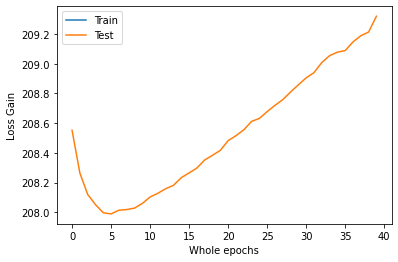

In [31]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('Whole epochs')
plt.ylabel('Loss Gain')
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Test')
plt.legend()
plt.show()

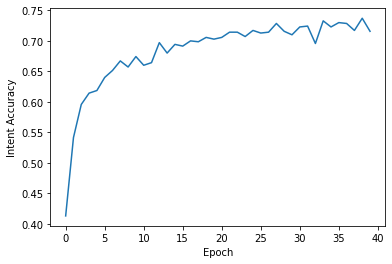

In [32]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Intent Accuracy')
plt.plot(intent_acc)
plt.show()

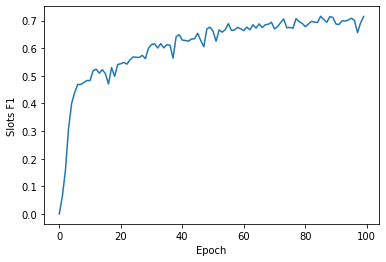

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Slots F1 accuracy')
plt.plot(slots_f1)
plt.show()

## Multiple runs

# Experimenting with ATIS

In [51]:
import numpy as np
from sklearn.metrics import classification_report
import importlib
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

DATASET = 'ATIS'
NUM_EPOCHS = 100

lang = Lang()
lang.build_vocab(dataset[DATASET]['train'] + dataset[DATASET]['test'])
lang.build_intents(dataset[DATASET]['train'] + dataset[DATASET]['test'])
lang.build_slots(dataset[DATASET]['train'] + dataset[DATASET]['test'])

print("Vocab size =", lang.vocab_size)
print("No. intents =", lang.num_intents)
print("No. slots =", lang.num_slots)

train_dataset = Dataset(dataset[DATASET]['train'], lang)
test_dataset = Dataset(dataset[DATASET]['test'], lang)

train_loader = DataLoader(train_dataset, batch_size=128, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)

valid_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)

# -------- Un-comment the model you'd like to run and comment the rest -----
model = BiModelRNN(200, 50, lang.num_intents, lang.num_slots, lang.vocab_size)
#model = BERT(lang.num_intents, lang.num_slots, lang)
#model = AttentionBiRNN(200, 50, lang.num_intents, lang.num_slots, lang.vocab_size)
# --------------------------------------------------------------------------

model.train()
model.to(DEVICE)

# -------- Can experiment with other optimizers (e.g. SGD or rmsprop) ------
optimizer = optim.Adam(model.parameters())
# --------------------------------------------------------------------------

intent_loss_fn = nn.CrossEntropyLoss(ignore_index=0)
slot_loss_fn = nn.CrossEntropyLoss()

train_loss = []
test_loss = []
intent_acc = []
slots_f1 = []
ref_slots = []
hyp_slots = []

for epoch in tqdm(range(NUM_EPOCHS)):
    total_loss_values = []

    loss_array = train_loop(train_loader,optimizer,slot_loss_fn,intent_loss_fn,model)

    #print(loss_array)
    train_loss.append(np.mean(total_loss_values))

    ref_slots, hyp_slots, test_loss, slots_f1, report_intent = eval_loop(test_loader,model,lang)
    
    intent_acc.append(report_intent['accuracy'])

    print("Training loss =", train_loss[-1])
    print("Training perplexity =", np.exp(train_loss[-1]))
    print("Validation loss =", test_loss[-1])
    print("Validation perplexity =", np.exp(test_loss[-1]))
    print("Slot filling F1 =", slots_f1[-1])
    print("Intent detection acc. =", intent_acc[-1])

ref_slots, hyp_slots, _, _, report_intent = eval_loop(valid_loader,model,lang)

Vocab size = 943
No. intents = 26
No. slots = 129


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.18271418980189
Validation perplexity = 4.318815977072356e+85
Slot filling F1 = 0.0
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 195.81808580671037
Validation perplexity = 1.103352091809635e+85
Slot filling F1 = 0.2648284078377616
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 194.6161825997489
Validation perplexity = 3.3169138529372015e+84
Slot filling F1 = 0.40238251973766237
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 194.31039101736886
Validation perplexity = 2.4430400987377982e+84
Slot filling F1 = 0.5491583844505259
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 194.4352046421596
Validation perplexity = 2.7678112091976934e+84
Slot filling F1 = 0.6452570963205967
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 194.59915597098214
Validation perplexity = 3.260916071663614e+84
Slot filling F1 = 0.6852767972865463
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 194.75868225097656
Validation perplexity = 3.824908094762359e+84
Slot filling F1 = 0.7321855567600248
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 194.91664341517858
Validation perplexity = 4.479429092868058e+84
Slot filling F1 = 0.7878501366743249
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 195.06667981828963
Validation perplexity = 5.204543566096323e+84
Slot filling F1 = 0.8174555600515684
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 195.21372549874442
Validation perplexity = 6.028979065764633e+84
Slot filling F1 = 0.827854010458478
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 195.3524660382952
Validation perplexity = 6.926247822359258e+84
Slot filling F1 = 0.8440532078344579
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 195.47453962053572
Validation perplexity = 7.82553268630112e+84
Slot filling F1 = 0.8522086811045655
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 195.60611397879464
Validation perplexity = 8.925980372530597e+84
Slot filling F1 = 0.8605041066275504
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 195.73423767089844
Validation perplexity = 1.0146104709838432e+85
Slot filling F1 = 0.863514695640379
Intent detection acc. = 0.7066069428891377


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 195.86417606898718
Validation perplexity = 1.1553960255790345e+85
Slot filling F1 = 0.8634392702570031
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 195.9647434779576
Validation perplexity = 1.2776348221589005e+85
Slot filling F1 = 0.8698156672828959
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 196.0500760759626
Validation perplexity = 1.3914455509535772e+85
Slot filling F1 = 0.8687926763382926
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 196.1305215018136
Validation perplexity = 1.5080065262369283e+85
Slot filling F1 = 0.8700691929695289
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 196.1984143938337
Validation perplexity = 1.613944994997491e+85
Slot filling F1 = 0.8729760878005394
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 196.2702854701451
Validation perplexity = 1.7342110186047075e+85
Slot filling F1 = 0.8754198180158261
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 196.33229609898157
Validation perplexity = 1.845154833352626e+85
Slot filling F1 = 0.8762664580002041
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 196.3858141217913
Validation perplexity = 1.9465940751176014e+85
Slot filling F1 = 0.8769053177096124
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 196.4251262119838
Validation perplexity = 2.0246428355377257e+85
Slot filling F1 = 0.879598220178551
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 196.4792022705078
Validation perplexity = 2.1371418794491888e+85
Slot filling F1 = 0.8824711342496733
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 196.5204097202846
Validation perplexity = 2.2270477195882202e+85
Slot filling F1 = 0.8816686767842817
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 196.56485530308314
Validation perplexity = 2.32826277320946e+85
Slot filling F1 = 0.8817124615425123
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 196.61537715366907
Validation perplexity = 2.448912991527096e+85
Slot filling F1 = 0.881458932565579
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 196.66241782052177
Validation perplexity = 2.566863988897872e+85
Slot filling F1 = 0.8825612954260607
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 196.7011729649135
Validation perplexity = 2.668295983969915e+85
Slot filling F1 = 0.8825541046573917
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 196.74407632010323
Validation perplexity = 2.7852660978224216e+85
Slot filling F1 = 0.8840682058355466
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 196.78936658586775
Validation perplexity = 2.9143117377464558e+85
Slot filling F1 = 0.8808522355423086
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 196.8161882672991
Validation perplexity = 2.993536195890462e+85
Slot filling F1 = 0.8840795979522019
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 196.84899357387
Validation perplexity = 3.093368632322694e+85
Slot filling F1 = 0.8844167561281059
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 196.8811972481864
Validation perplexity = 3.1946078565494795e+85
Slot filling F1 = 0.8836775612679701
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 196.9159415108817
Validation perplexity = 3.3075528852999674e+85
Slot filling F1 = 0.8829707652644219
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 196.92835889543807
Validation perplexity = 3.3488800983418794e+85
Slot filling F1 = 0.8842369061162288
Intent detection acc. = 0.7066069428891377


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 196.95763070242745
Validation perplexity = 3.4483566972645346e+85
Slot filling F1 = 0.8814848615948675
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 196.9864055088588
Validation perplexity = 3.549023887336699e+85
Slot filling F1 = 0.8821007630506347
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.00985826764787
Validation perplexity = 3.633242001880689e+85
Slot filling F1 = 0.8837043852589601
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.0322505405971
Validation perplexity = 3.715516264591594e+85
Slot filling F1 = 0.8824968954736427
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.0647474016462
Validation perplexity = 3.838242183778182e+85
Slot filling F1 = 0.8828146690276985
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.0827157156808
Validation perplexity = 3.9078322605408674e+85
Slot filling F1 = 0.8812726873065455
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.08878653390067
Validation perplexity = 3.931628157026602e+85
Slot filling F1 = 0.884104638234801
Intent detection acc. = 0.7066069428891377


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.1112060546875
Validation perplexity = 4.020768888723706e+85
Slot filling F1 = 0.883838498998897
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.13792855398995
Validation perplexity = 4.129662355423186e+85
Slot filling F1 = 0.8812508726150778
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.15562002999442
Validation perplexity = 4.203372274000002e+85
Slot filling F1 = 0.8851745276585539
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.1746063232422
Validation perplexity = 4.2839411646454626e+85
Slot filling F1 = 0.8829804606828519
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.1907457624163
Validation perplexity = 4.3536425299844196e+85
Slot filling F1 = 0.8860405398347563
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.20147051130022
Validation perplexity = 4.400585528837404e+85
Slot filling F1 = 0.8867903561500822
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.22449820382255
Validation perplexity = 4.5030966264522686e+85
Slot filling F1 = 0.8842196097383502
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.24175916399275
Validation perplexity = 4.581499102373089e+85
Slot filling F1 = 0.8850034843184175
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.26041957310267
Validation perplexity = 4.667794398661096e+85
Slot filling F1 = 0.8848571642952777
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.27714102608817
Validation perplexity = 4.746502929799742e+85
Slot filling F1 = 0.8824043912378013
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.28704289027624
Validation perplexity = 4.793735617088623e+85
Slot filling F1 = 0.8850624647805333
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.2832260131836
Validation perplexity = 4.7754733919291655e+85
Slot filling F1 = 0.8859078679775603
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.31350925990515
Validation perplexity = 4.922302237022589e+85
Slot filling F1 = 0.8835078044352797
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.35234723772322
Validation perplexity = 5.1172354048451406e+85
Slot filling F1 = 0.8874807445224414
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.36314501081193
Validation perplexity = 5.172789542310921e+85
Slot filling F1 = 0.8875086188504276
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.37799181256975
Validation perplexity = 5.250161867725034e+85
Slot filling F1 = 0.8828868128848366
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.38853345598494
Validation perplexity = 5.305799945156337e+85
Slot filling F1 = 0.8833894830403625
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.40056937081474
Validation perplexity = 5.370045955583067e+85
Slot filling F1 = 0.8849143672640147
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.41481563023157
Validation perplexity = 5.447096561655909e+85
Slot filling F1 = 0.8851055721024761
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.42693328857422
Validation perplexity = 5.513504156429294e+85
Slot filling F1 = 0.8839935076085527
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.443852015904
Validation perplexity = 5.607579200877564e+85
Slot filling F1 = 0.8854182866369151
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.45012010846818
Validation perplexity = 5.642838414936827e+85
Slot filling F1 = 0.8869503678442483
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.46901920863561
Validation perplexity = 5.7504971051486124e+85
Slot filling F1 = 0.8837746335374949
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.48068237304688
Validation perplexity = 5.817958741682827e+85
Slot filling F1 = 0.8853518357305985
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.49390847342355
Validation perplexity = 5.895418765846559e+85
Slot filling F1 = 0.8862782329615871
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.49937220982142
Validation perplexity = 5.927717936665171e+85
Slot filling F1 = 0.884959898440565
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.5174070085798
Validation perplexity = 6.035592965081072e+85
Slot filling F1 = 0.886397001837355
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.53236389160156
Validation perplexity = 6.126545107749538e+85
Slot filling F1 = 0.8857997640620655
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.54617745535714
Validation perplexity = 6.211761746892235e+85
Slot filling F1 = 0.8863036834349658
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.55411965506417
Validation perplexity = 6.261293233332901e+85
Slot filling F1 = 0.8854004744130559
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.67487226213728
Validation perplexity = 7.064903503405327e+85
Slot filling F1 = 0.8613856716880233
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.86276245117188
Validation perplexity = 8.525226115907887e+85
Slot filling F1 = 0.8795196218488492
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 197.9840360369001
Validation perplexity = 9.624415320495791e+85
Slot filling F1 = 0.8794743177030245
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 198.05771418980189
Validation perplexity = 1.0360300946589248e+86
Slot filling F1 = 0.8843658116762656
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 198.12386866978235
Validation perplexity = 1.1068860054244563e+86
Slot filling F1 = 0.878521575036956
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 198.14773668561662
Validation perplexity = 1.1336229882063543e+86
Slot filling F1 = 0.8852726999851696
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 198.17364065987724
Validation perplexity = 1.163371973909168e+86
Slot filling F1 = 0.8830724304276771
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 198.17948259626115
Validation perplexity = 1.1701882095937114e+86
Slot filling F1 = 0.8888053686354194
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 198.18763732910156
Validation perplexity = 1.1797697963584367e+86
Slot filling F1 = 0.8848800293237419
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 198.19884272984095
Validation perplexity = 1.1930639336730901e+86
Slot filling F1 = 0.8862531429588933
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 198.21943010602678
Validation perplexity = 1.2178805678637908e+86
Slot filling F1 = 0.8868745819901869
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 198.2273690359933
Validation perplexity = 1.2275877176066235e+86
Slot filling F1 = 0.8878690895356462
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 198.23674665178572
Validation perplexity = 1.2391537095290899e+86
Slot filling F1 = 0.8859840578073894
Intent detection acc. = 0.7054871220604704


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 198.2572239467076
Validation perplexity = 1.2647898086703755e+86
Slot filling F1 = 0.887085214955579
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 198.27395629882812
Validation perplexity = 1.2861307613723552e+86
Slot filling F1 = 0.8868358003164668
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 198.28216116768974
Validation perplexity = 1.2967267053305538e+86
Slot filling F1 = 0.8875636838551008
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 198.30323573521204
Validation perplexity = 1.3243446558487105e+86
Slot filling F1 = 0.8878996301037009
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 198.30696977887834
Validation perplexity = 1.3292990608485455e+86
Slot filling F1 = 0.889411388222402
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 198.3173348563058
Validation perplexity = 1.3431490023997968e+86
Slot filling F1 = 0.8881235942694343
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 198.3296356201172
Validation perplexity = 1.3597727940995475e+86
Slot filling F1 = 0.8890754419738016
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 198.3499537876674
Validation perplexity = 1.3876834722925778e+86
Slot filling F1 = 0.8860519257363997
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 198.3482393537249
Validation perplexity = 1.385306418878983e+86
Slot filling F1 = 0.889411388222402
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 198.36214338030135
Validation perplexity = 1.4047022839860307e+86
Slot filling F1 = 0.8887394957252015
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 198.3704594203404
Validation perplexity = 1.4164325515078473e+86
Slot filling F1 = 0.8892807424590573
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 198.38372693743025
Validation perplexity = 1.4353503129509453e+86
Slot filling F1 = 0.8899846298370769
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 198.3935546875
Validation perplexity = 1.449526121142165e+86
Slot filling F1 = 0.8899846298370769
Intent detection acc. = 0.7077267637178052


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training loss = nan
Training perplexity = nan
Validation loss = 198.4010947091239
Validation perplexity = 1.4604968873715626e+86
Slot filling F1 = 0.8887466056987168
Intent detection acc. = 0.7077267637178052


In [ ]:
for ref, hyp in zip(ref_slots, hyp_slots):
        evaluate(ref, hyp)

# Slots

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Test')
plt.legend()
plt.show()